In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.appName("Spark_CLOB_Split") \
.config("hive.metastore.sasl.enabled", "true") \
.enableHiveSupport() \
.getOrCreate()

In [3]:
# 定义 sparkContext,这个环境被包含在了 SparkSession 之中。
sc = spark.sparkContext

4.1.1 重复数据

In [4]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
],['id','weight','height','age','gender'])

In [5]:
print("Count of rows: {}".format(df.count()))
print("count of distinct:{}".format(df.distinct().count()))

Count of rows: 7
count of distinct:6


In [8]:
# 利用.dropDuplicates()去除重复数据
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [9]:
print("Count of ids:{}".format(df.count()))

#不考虑id,计算不重复的值
print("Count of distinct ids:{}".format(
    df.select([
        c for c in df.columns if c != 'id'
    ]).distinct().count()
))

Count of ids:6
Count of distinct ids:5


In [10]:
#加入subset参数，只处理id以外的列
df = df.dropDuplicates(subset = [c for c in df.columns if c != 'id'])

In [11]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [14]:
#用agg()方法计算ID的总数和ID的唯一个数
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()   #alias()后接列名

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



In [16]:
#增加一列，添加新的id
#fn.monotonically_increasing_id()为每一行记录提供了一个唯一且递增的id
df.withColumn('new id',fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



4.1.2 未观测数据（缺失数据）

In [17]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [22]:
#查找每行缺失的观测数据
df_miss.rdd.map(lambda row: (row['id'],sum([c == None for c in row]))).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [24]:
#我们可以观察到id=3有４个缺失值
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



In [26]:
#现在来检查每一列中缺失的观测数据的百分比
df_miss.agg(*[
    (1-fn.count(c)/fn.count("*")).alias(c+'_missing')
    for c in df_miss.columns
]).show() 
#fn.count(c):c的行数，fn.count(*)：所有列的行数

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [28]:
#由上表所示，income的缺失值达到了７１％，现在需要移除这一列
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [29]:
#如上表所示，现在我们要移除每一组数据中，缺失的数量大于３的数据，如id=3的数据中，有３个缺失值，应该移除。
#我们设置阈值 thresh = 3
#.dropna():移除一行数据
df_miss_no_income.dropna(thresh = 3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [31]:
#使用 .fillna() 方法，对缺失值进行填充。这时，我们会需要先计算出需要填充的值，用dataframe表示，然后再转换为字典的形式去传参。
#例如：计算每一列的平均值，来填充缺失的值
means = df_miss_no_income.agg(
*[fn.mean(c).alias(c) 
  for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('record')[0]

"""
转换为字典的格式
df.to_dict('records')
=> [{'col1': 1, 'col2': 0.5}, {'col1': 2, 'col2': 0.75}]
"""


In [35]:
#性别没有平均值，用missing代替
means['gender'] = 'missing'

In [36]:
print(means) #means为字典，存放平均值

{'id': 4.0, 'weight': 140.28333333333333, 'height': 5.471428571428571, 'age': 40.4, 'gender': 'missing'}


In [37]:
#将缺失项用平均值填充,使用 .fillna() 方法.
df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



4.1.3 离群值

定义：指那些与样本其余部分的分布显著偏离的观测数据。
通常，在范围 Q1 - 1.5IQR 到 Q3 + 1.5IQR 之间的值都不是离群值。
其中 Q1 和 Q3 分别表示第25个百分位（上分位）和第75个百分位（下分位）。 而 IQR 定义为上分位和下分位的差值。

In [38]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])


使用 approxQuantile() 方法，来计算每个特征的上下分位,有三个参数 (col, probabilities, relativeError)
   1) col: DataFrame 中列的名字，也就是我们接下来要进行计算的列。
   2) probabilities： 分位数概率列表，每个数字必须属于[0，1]。 例如，0是最小值，0.5是中位数，1是最大值。
   3) relativeError： 每次度量可以接受的误差范围，不建议设置为0


In [41]:
#现在我们先来计算不是离群值的范围：【Q1 - 1.5IQR ，Q3 + 1.5IQR】

cols = ['weight','height','age']
bound = {}
for col in cols:    
    quantiles = df_outliers.approxQuantile(col,[0.25,0.75],0.05)  #求得上分位和下分位
    IQR = quantiles[1] - quantiles[0]
    
    bound[col] = [
        quantiles[0] - 1.5*IQR,
        quantiles[1] + 1.5*IQR,
    ]

#界限bound保存了每个特征的上下界限
print(bound)

{'weight': [91.69999999999999, 191.7], 'height': [4.499999999999999, 6.1000000000000005], 'age': [-11.0, 93.0]}


计算出特征的上下分位之后，我们相当于从数据中统计出了正常值区间，接下来，我们对数据进行筛选。

In [44]:
outliers = df_outliers.select(*['id']+[(
    (df_outliers[c] < bound[c][0])|
    (df_outliers[c] > bound[c][1])
).alias(c + '_o') for c in cols])

outliers.show() #true为离群值

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



通过上面的步骤，我们已经可以看出离群值是哪些了。但是如果我们想更进一步更加值观的把离群值给列出来，我们就需要利用 .filter() 函数了。

In [45]:
#1. 连接两个表
df_outliers = df_outliers.join(outliers, on = 'id')
df_outliers.show()

+---+------+------+---+--------+--------+-----+
| id|weight|height|age|weight_o|height_o|age_o|
+---+------+------+---+--------+--------+-----+
|  7| 129.2|   5.3| 42|   false|   false|false|
|  6| 124.1|   5.1| 21|   false|   false|false|
|  5| 133.2|   5.4| 54|   false|   false|false|
|  1| 143.5|   5.3| 28|   false|   false|false|
|  3| 342.3|   5.1| 99|    true|   false| true|
|  2| 154.2|   5.5| 45|   false|   false|false|
|  4| 144.5|   5.5| 33|   false|   false|false|
+---+------+------+---+--------+--------+-----+



In [47]:
#2.利用 filter 进行过滤
df_outliers.filter('weight_o').select('id','weight').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+



In [48]:
df_outliers.filter('age_o').select('id','age').show()

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



4.2 熟悉你的数据：ccFraud 数据集

4.2.1 描述性统计

In [77]:
import findspark
findspark.init()

In [78]:
from pyspark.sql import SparkSession

sc = SparkSession.builder \
.appName("Spark_Chapter_4") \
.config("hive.metastore.sasl.enabled", "true") \
.enableHiveSupport() \
.getOrCreate()

In [79]:
#首先加载数据，并且转换为spark dataframe形式
import pyspark.sql.types as typ  #显示了我们可以使用的数据类型

In [81]:
fraud = sc.sparkContext.textFile('file:///home/yanglab/lianhaimiao/PySpark/spark_data/chapter04data/ccFraud.csv')
header = fraud.first()

In [82]:
print(header)

"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"


In [83]:
#读取数据，用.filter()方法，删除标题行。
#接下来，以每一个逗号分割出行，将每个元素转换为整型。
fraud = fraud.filter(lambda row: row != header).map(lambda row: [int(elem) for elem in row.split(',')])

In [84]:
#然后，创建dataframe形式
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)


fraud_df = sc.createDataFrame(fraud,schema)

In [85]:
fraud_df.take(5)

[Row(custID=1, gender=1, state=35, cardholder=1, balance=3000, numTrans=4, numIntlTrans=14, creditLine=2, fraudRisk=0),
 Row(custID=2, gender=2, state=2, cardholder=1, balance=0, numTrans=9, numIntlTrans=0, creditLine=18, fraudRisk=0),
 Row(custID=3, gender=2, state=2, cardholder=1, balance=0, numTrans=27, numIntlTrans=9, creditLine=16, fraudRisk=0),
 Row(custID=4, gender=1, state=15, cardholder=1, balance=0, numTrans=12, numIntlTrans=0, creditLine=5, fraudRisk=0),
 Row(custID=5, gender=1, state=46, cardholder=1, balance=0, numTrans=11, numIntlTrans=16, creditLine=7, fraudRisk=0)]

In [66]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [86]:
#使用groupby()计算某个列的分类出现的频率
#由下图可见，我们正在处理一个男女比例严重失衡的数据
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [87]:
#我们可以用.describe()的方法，显示数值特征
numerical = ['balance','numTrans','numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [88]:
#如何检查偏度
fraud_df.agg({'balance':'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



4.2.2 相关性
　　检查特征之间的相关性

In [89]:
#.corr() 只能计算两两相关性
fraud_df.corr('balance','numTrans')

0.0004452314017265385

In [90]:
#下面我们利用.corr()创建一个相关性矩阵
numerical = ['balance','numTrans','numIntlTrans']
n_numerical = len(numerical)

corr = []

In [91]:
for i in range(0,n_numerical):
    temp = [None]*i
    
    for j in range(i,n_numerical):
        temp.append(fraud_df.corr(numerical[i],numerical[j]))
    corr.append(temp)

In [92]:
print(corr)
#证明该数据集中数值型特征间的相关性几乎不存在

[[1.0, 0.0004452314017265386, 0.0002713991339817875], [None, 1.0, -0.00028057128198165544], [None, None, 1.0]]


4.3 可视化

4.3.1　直方图

In [93]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [94]:
#对数据进行聚合，选择'balance'列的数据
hists = fraud_df.select('balance').rdd.flatMap(lambda row:row).histogram(20)

Text(0.5, 1.0, "Histogram of 'balance'")

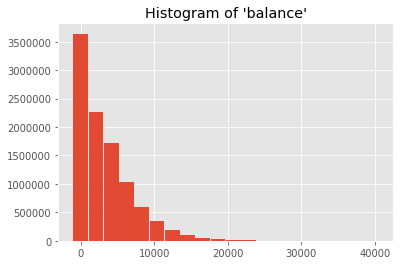

In [95]:
#调用matplotlib，绘制直方图
data = {
    'bins':hists[0][:-1],
    'freq':hists[1]
}
plt.bar(data['bins'],data['freq'],width=2000)
plt.title('Histogram of \'balance\'')

In [96]:
plt.savefig('B05793_05_22.png', dpi=300)

<Figure size 432x288 with 0 Axes>